In [36]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import zipfile
from bioservices import KEGG
from K_func import translate_ko_terms
import sys




'''
Data prep and feature mapping
'''
# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"







Features with zero variance after filtering: 0


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found: {'estimator': SVC(random_state=42), 'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'select_k__k': 100}
Best cross-validation score: 0.962


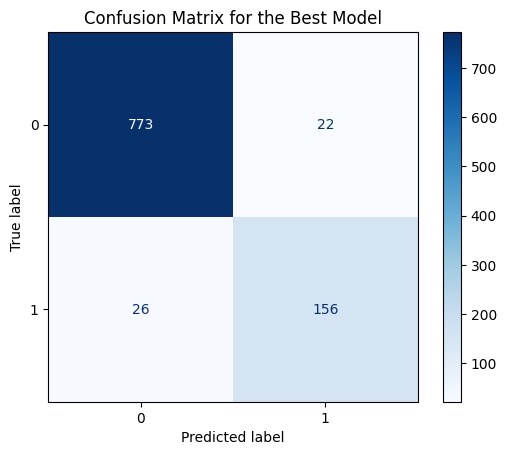

Class distribution in Y_train:
 aerobic      1909
anaerobic     370
Name: count, dtype: int64
Unique labels in Y_train: ['aerobic' 'anaerobic']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279


In [37]:
''' Pipeline implementation for Naive bayes and random forests'''

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 20, 30, 40, 50, 100],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 20, 30, 40, 50,100],  # May need as needed  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k' : [10,20,30,40,50, 100],
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 20, 30, 40, 50, 100],  
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)


# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

# Calculate accuracy and other metrics as needed
#print("Accuracy on test set:", accuracy_score(Y_test, Y_pred))
#print("F1 Score on test set:", f1_score(Y_test, Y_pred, average='macro'))
#print("Classification Report:\n", classification_report(Y_test, Y_pred))

# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for the Best Model')
plt.show()



In [50]:
kegg = KEGG()
def translate_ko_terms(ko_terms):
    ko_descriptions = {}
    for ko in ko_terms:
        try:
            result = kegg.find("ko", ko)
            # The result can contain multiple lines if the term has multiple entries; split by newline
            first_line = result.split('\n')[0]
            # Each line is tab-separated with the format: entry_id, description
            _, description = first_line.split('\t', 1)
            ko_descriptions[ko] = description
        except Exception as e:
            print(f"Error retrieving information for {ko}: {e}")
            ko_descriptions[ko] = ko  # Use the KO term itself if the name can't be retrieved
    return ko_descriptions


In [ ]:
''' Finding best traits '''

# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=10)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

''' Plot for visualizing distribution and importance of best traits'''

# Translate selected KO terms to their descriptions
selected_ko_terms_list = list(sorted_features)  
ko_descriptions_mapping = translate_ko_terms(selected_ko_terms_list)


# Replace KO terms with their descriptions for plotting
translated_sorted_features = [ko_descriptions_mapping[ko] for ko in sorted_features]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(translated_sorted_features)), sorted_scores)
plt.xticks(range(len(translated_sorted_features)), translated_sorted_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('F-scores')
plt.title('Top 50 KO Descriptions by F-score')
plt.tight_layout()
plt.show()


Most selected KO terms for predicting oxygen trait in hierchical manner (F score):
Index(['K01589', 'K00164', 'K01772', 'K05919', 'K01599', 'K00254', 'K02259',
       'K04070', 'K02257', 'K01163'],
      dtype='object', name='KO')
Error retrieving information for K01589: 'DEFINITION'
Error retrieving information for K00164: 'DEFINITION'


KeyboardInterrupt: 

In [38]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 0    1909
1     370
Name: count, dtype: int64
Unique labels in Y_train: [0 1]
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279


In [55]:
''' K values versus f1 score plot'''


# Define the range of `k` values to explore
k_values = range(1, 3000, 100)  # Range of steps

# Define estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines' : SVC(),
    'LogisticRegression' : LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store results
results = {name: [] for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")  # Debug print
    # Loop over each `k` value
    for k in k_values:
        print(f"Testing with k={k}")  # Debug print
        # Define the pipeline for the current estimator
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        
        # Perform cross-validation using StratifiedKFold
        cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)
        
        # Store the mean F1 score for this `k`
        results[name].append(cv_scores.mean())


# Checking the first feature
selector = SelectKBest(score_func=f_classif, k=1)
selector.fit(X_train, Y_train)
selected_mask = selector.get_support()

selected_feature_name = X_train.columns[selected_mask][0]
print(f"The most informative feature for k=1 is:", translate_ko_terms({selected_feature_name[0]}))


# For debugging 
print(results)


Processing estimator: RandomForestClassifier
Testing with k=1
Testing with k=101
Testing with k=201
Testing with k=301
Testing with k=401
Testing with k=501
Testing with k=601
Testing with k=701
Testing with k=801
Testing with k=901
Testing with k=1001
Testing with k=1101
Testing with k=1201
Testing with k=1301
Testing with k=1401
Testing with k=1501
Testing with k=1601
Testing with k=1701
Testing with k=1801
Testing with k=1901
Testing with k=2001
Testing with k=2101
Testing with k=2201
Testing with k=2301
Testing with k=2401
Testing with k=2501
Testing with k=2601
Testing with k=2701
Testing with k=2801
Testing with k=2901
Processing estimator: SupportVectorMachines
Testing with k=1
Testing with k=101
Testing with k=201
Testing with k=301
Testing with k=401
Testing with k=501
Testing with k=601
Testing with k=701
Testing with k=801
Testing with k=901
Testing with k=1001
Testing with k=1101
Testing with k=1201
Testing with k=1301
Testing with k=1401
Testing with k=1501
Testing with k=

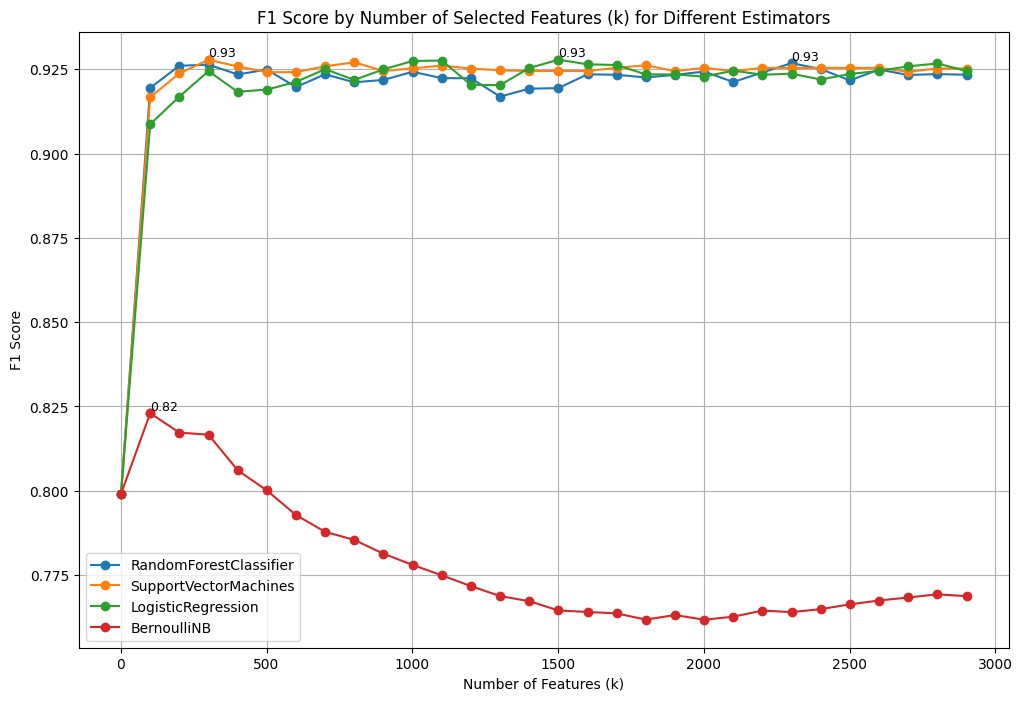

In [56]:
''' Plot for F1 vs K features '''

# Plotting the results for each estimator
plt.figure(figsize=(12, 8))

for name, scores in results.items():
    k_values_list = list(k_values)  # Convert range to list for indexing

    # Filter out non-finite scores and corresponding k values
    finite_scores = [score for score in scores if np.isfinite(score)]
    finite_k_values = [k for k, score in zip(k_values_list, scores) if np.isfinite(score)]

    if not finite_scores:  # Skips if no finite scores are found
        print(f"No finite scores for {name}, skipping.")
        continue

    max_f1_score_index = finite_scores.index(max(finite_scores))  # Index of the highest F1 score for this estimator
    max_f1_score = finite_scores[max_f1_score_index]  # The highest F1 score
    best_k = finite_k_values[max_f1_score_index]  # `k` value for the highest F1 score

    # Plot F1 scores
    plt.plot(finite_k_values, finite_scores, marker='o', linestyle='-', label=name)
    
    # Highlight the point with the highest F1 score
    plt.scatter([best_k], [max_f1_score], color='red')  # Highlight with red color
    if np.isfinite(max_f1_score) and np.isfinite(best_k):  # Ensures finite
        plt.text(best_k, max_f1_score, f"{max_f1_score:.2f}", fontsize=9, verticalalignment='bottom')

plt.title('F1 Score by Number of Selected Features (k) for Different Estimators')
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()



In [58]:
# Initialize and fit SelectKBest with k=1
selector = SelectKBest(score_func=f_classif, k=1)
selector.fit(X_train, Y_train)

# Get the boolean mask of the selected feature
selected_mask = selector.get_support()

# Apply the mask to the list of feature names to get the selected feature's name
selected_feature = [column for (column, is_selected) in zip(X_train.columns, selected_mask) if is_selected]

print(f"Feature for K=1 is:", translate_ko_terms({selected_feature[0]}))




Feature for K=1 is: {'K01589': 'purK; 5-(carboxyamino)imidazole ribonucleotide synthase [EC:6.3.4.18]'}
